# Notebook of my thought process for building the pipeline

In [ ]:
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import rasterio
import os
import sqlite3


# Set filenames and constants

In [ ]:
raster_file = "data/inputs/NLS_TotalEcosystemCarbon2020.tif"
raster_nodata = 65535
boundary_file = "data/inputs/US_census_counties/cb_2024_us_county_500k.shp"
export_crs = "EPSG:4326"    

SQ_M_IN_ACRE = 4046.86
SQ_M_IN_SQ_MILE = 2589988.11
# each pixel is 30m x 30m = 900 sq meters, this value adjusts the pixel from MgCO2e/acre to just MgCO2e
PIXEL_AREA_ADJUST = 900 / SQ_M_IN_ACRE  


# Load raster and check values

In [4]:
# Open the raster file
with rasterio.open(raster_file) as src:
    # Read the first band as a numpy array
    raster_crs = src.crs.to_string()
    # raster_nodata = src.nodata




# Load Polygon Boundaries, Narrow to Michigan, WIsconsin, Minnesota

In [5]:
# Load polygon boundaries
gdf = gpd.read_file(boundary_file)
mask = gdf['STATE_NAME'].isin(['Michigan', 'Wisconsin', 'Minnesota'])
gdf = gdf[mask].to_crs(raster_crs)

print(f"Raster CRS: {raster_crs}")
print(f"Polygon CRS: {gdf.crs}")
print(gdf['STATE_NAME'].value_counts())
gdf.head()

Raster CRS: EPSG:5070
Polygon CRS: EPSG:5070
STATE_NAME
Minnesota    87
Michigan     83
Wisconsin    72
Name: count, dtype: int64


,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
30,27,087,00659488,0500000US27087,27087,Mahnomen,Mahnomen County,MN,Minnesota,06,1444868083,64851532,"POLYGON ((-5127.48 2722880.903, -1879.895 2722..."
38,27,053,00659472,0500000US27053,27053,Hennepin,Hennepin County,MN,Minnesota,06,1434901813,136571331,"POLYGON ((175982.379 2437263.302, 175971.634 2..."
66,26,103,01622994,0500000US26103,26103,Marquette,Marquette County,MI,Michigan,06,4685463544,4185295221,"MULTIPOLYGON (((659980.485 2652567.064, 660027..."
67,26,053,01622969,0500000US26053,26053,Gogebic,Gogebic County,MI,Michigan,06,2854517947,970153215,"POLYGON ((429071.487 2632246.414, 429346.073 2..."
68,26,115,01623000,0500000US26115,26115,Monroe,Monroe County,MI,Michigan,06,1422841177,338180469,"POLYGON ((1001838.421 2184665.346, 1006877.235..."


In [6]:
print(f"There are {len(gdf)} counties in MI, WI, and MN.")
print(f"So only attributes with {len(gdf)} unique values are unique identifiers.")
gdf.nunique()

There are 242 counties in MI, WI, and MN.
So only attributes with 242 unique values are unique identifiers.


STATEFP         3
COUNTYFP       88
COUNTYNS      242
GEOIDFQ       242
GEOID         242
NAME          223
NAMELSAD      223
STUSPS          3
STATE_NAME      3
LSAD            1
ALAND         242
AWATER        242
geometry      242
dtype: int64

In [7]:
# Compute the sum of raster values within each polygon
stats = zonal_stats(gdf, raster_file, stats=["sum"], nodata=raster_nodata)
gdf["raster_sum"] = [s["sum"] for s in stats]


gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 242 entries, 30 to 3225
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP     242 non-null    object  
 1   COUNTYFP    242 non-null    object  
 2   COUNTYNS    242 non-null    object  
 3   GEOIDFQ     242 non-null    object  
 4   GEOID       242 non-null    object  
 5   NAME        242 non-null    object  
 6   NAMELSAD    242 non-null    object  
 7   STUSPS      242 non-null    object  
 8   STATE_NAME  242 non-null    object  
 9   LSAD        242 non-null    object  
 10  ALAND       242 non-null    int64   
 11  AWATER      242 non-null    int64   
 12  geometry    242 non-null    geometry
 13  raster_sum  242 non-null    float64 
dtypes: float64(1), geometry(1), int64(2), object(10)
memory usage: 28.4+ KB


In [12]:
gdf['Mg_CO2e'] = gdf['raster_sum'] * PIXEL_AREA_ADJUST
gdf['Tg_CO2e'] = gdf['Mg_CO2e'] / 1e6  # convert from Mg to Tg
gdf['county_area_sq_miles'] = gdf.geometry.area / SQ_M_IN_SQ_MILE  # convert from sq meters to sq miles
gdf['county_area_acres'] = gdf.geometry.area / SQ_M_IN_ACRE  # convert from sq meters to acres
gdf['average_Mg_CO2e_per_acre'] = gdf['Mg_CO2e'] / gdf['county_area_acres']

gdf.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,raster_sum,Mg_CO2e,county_area_sq_miles,county_area_acres,average_Mg_CO2e_per_acre,Tg_CO2e
30,27,087,00659488,0500000US27087,27087,Mahnomen,Mahnomen County,MN,Minnesota,06,1444868083,64851532,"POLYGON ((-5127.48 2722880.903, -1879.895 2722...",120891547.0,2.688563e+07,582.895399,373052.725722,72.069257,26.885633
38,27,053,00659472,0500000US27053,27053,Hennepin,Hennepin County,MN,Minnesota,06,1434901813,136571331,"POLYGON ((175982.379 2437263.302, 175971.634 2...",46142351.0,1.026181e+07,606.767146,388330.629817,26.425451,10.261812


array([[<Axes: title={'center': 'average_Mg_CO2e_per_acre'}>]],
      dtype=object)

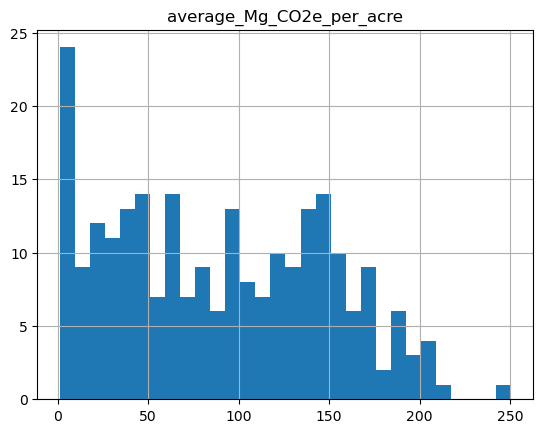

In [ ]:
# Look at histogram to check values and validate against statistics in QGIS
gdf[['average_Mg_CO2e_per_acre']].hist(bins=30)


In [10]:
gdf.sort_values('average_Mg_CO2e_per_acre', ascending=False).head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry,raster_sum,Mg_CO2e,county_area_sq_miles,county_area_acres,average_Mg_CO2e_per_acre
466,55,078,01581099,0500000US55078,55078,Menominee,Menominee County,WI,Wisconsin,06,926217566,19022479,"POLYGON ((551112.773 2479206.629, 551536.245 2...",263030932.0,5.849667e+07,364.997494,233598.189479,250.415773
67,26,053,01622969,0500000US26053,26053,Gogebic,Gogebic County,MI,Michigan,06,2854517947,970153215,"POLYGON ((429071.487 2632246.414, 429346.073 2...",708578985.0,1.575842e+08,1143.814322,732040.519146,215.267009
3109,26,131,01623008,0500000US26131,26131,Ontonagon,Ontonagon County,MI,Michigan,06,3395416358,6292279244,"POLYGON ((468549.074 2656807.415, 471110.325 2...",785932462.0,1.747872e+08,1327.648617,849694.363893,205.705933


#  Select Columns for Database and Export to Sqlite


In [ ]:
keep_cols = ['GEOID', 'NAME', 'STATE_NAME', 'Tg_CO2e', 'average_Mg_CO2e_per_acre', 'county_area_acres', 'geometry'] 

gdf_for_sql = gdf[keep_cols].to_crs(export_crs)
gdf_for_sql.head(2)

,GEOID,NAME,STATE_NAME,Tg_CO2e,average_Mg_CO2e_per_acre,county_area_acres,geometry
30,27087,Mahnomen,Minnesota,26.885633,72.069257,373052.725722,"POLYGON ((-96.06762 47.49914, -96.02479 47.499..."
38,27053,Hennepin,Minnesota,10.261812,26.425451,388330.629817,"POLYGON ((-93.76804 44.90544, -93.76794 44.912..."


## Clean dataframe for a database

In [ ]:

# Prepare a DB-friendly table: convert geometry to WKT and drop original geometry column
df = gdf_for_sql.drop(columns="geometry").copy()
geom_column_name = f"geometry_wkt_{export_crs.replace(":", "_")}"
df[geom_column_name] = gdf_for_sql.geometry.to_wkt()
rename_cols = {'GEOID': 'geoid', 'NAME': 'county_name', 'STATE_NAME': 'state_name', 'Tg_CO2e': 'total_Tg_CO2e', }
df = df.rename(columns=rename_cols)

df.head(2)

,geoid,county_name,state_name,total_Tg_CO2e,average_Mg_CO2e_per_acre,county_area_acres,geometry_wkt_EPSG_4326
30,27087,Mahnomen,Minnesota,26.885633,72.069257,373052.725722,"POLYGON ((-96.067623 47.499136, -96.024794 47...."
38,27053,Hennepin,Minnesota,10.261812,26.425451,388330.629817,"POLYGON ((-93.768044 44.905438, -93.767941 44...."


In [22]:
out_db = "data/outputs/county_carbon.sqlite"
os.makedirs(os.path.dirname(out_db), exist_ok=True)

# Write to SQLite
conn = sqlite3.connect(out_db)
df.to_sql("county_carbon", conn, if_exists="replace", index=False)
conn.close()

print(f"Exported {len(df)} rows to {out_db} (table: county_carbon).")

Exported 242 rows to data/outputs/county_carbon.sqlite (table: county_carbon).


# Example SQL queries

In [ ]:
# Example SQL query to read data back into a GeoDataFrame

#Connect to SQLite database file
conn = sqlite3.connect("data/outputs/county_carbon.sqlite")

# Query all columns for Minnesota counties with more than 6 Tg CO2e
query = """
SELECT *
FROM county_carbon
WHERE state_name = 'Minnesota'
  AND total_Tg_CO2e > 6;
"""

# Use pandas to execute query and load into DataFrame
df_from_sql = pd.read_sql_query(query, conn)

# Close the connection
conn.close()
# Transform df to a GeoDataFrame

gdf_from_sql = gpd.GeoDataFrame(
    df_from_sql,
    geometry=gpd.GeoSeries.from_wkt(df_from_sql['geometry_wkt_EPSG_4326']),
    crs='EPSG:4326'
)
gdf_from_sql = gdf_from_sql.drop(columns='geometry_wkt_EPSG_4326')

# Output the GeoDataFrame to verify
gdf_from_sql.head()

,geoid,county_name,state_name,total_Tg_CO2e,average_Mg_CO2e_per_acre,county_area_acres,geometry
0,27087,Mahnomen,Minnesota,26.885633,72.069257,3.730527e+05,"POLYGON ((-96.06762 47.49914, -96.02479 47.499..."
1,27053,Hennepin,Minnesota,10.261812,26.425451,3.883306e+05,"POLYGON ((-93.76804 44.90544, -93.76794 44.912..."
2,27075,Lake,Minnesota,209.668289,143.195233,1.464213e+06,"MULTIPOLYGON (((-91.55375 47.08965, -91.55327 ..."
3,27163,Washington,Minnesota,15.468979,57.073777,2.710348e+05,"POLYGON ((-93.0214 44.78971, -93.02035 44.7942..."
4,27015,Brown,Minnesota,7.272261,18.378212,3.957001e+05,"POLYGON ((-95.10878 44.19505, -95.10748 44.281..."
